# **Introduction to Geemap**

## **Basic Intro and Plan for the demonstartion**

Geemap is a powerful python module for achieving Google Earth Engine functions.

1. Supervised Classificaiton of three years
2. Accuracy Assessment
3. Inspector to inspect landcover changes over the years
4. Zonal statistics to determine each landcover class percentage over the years

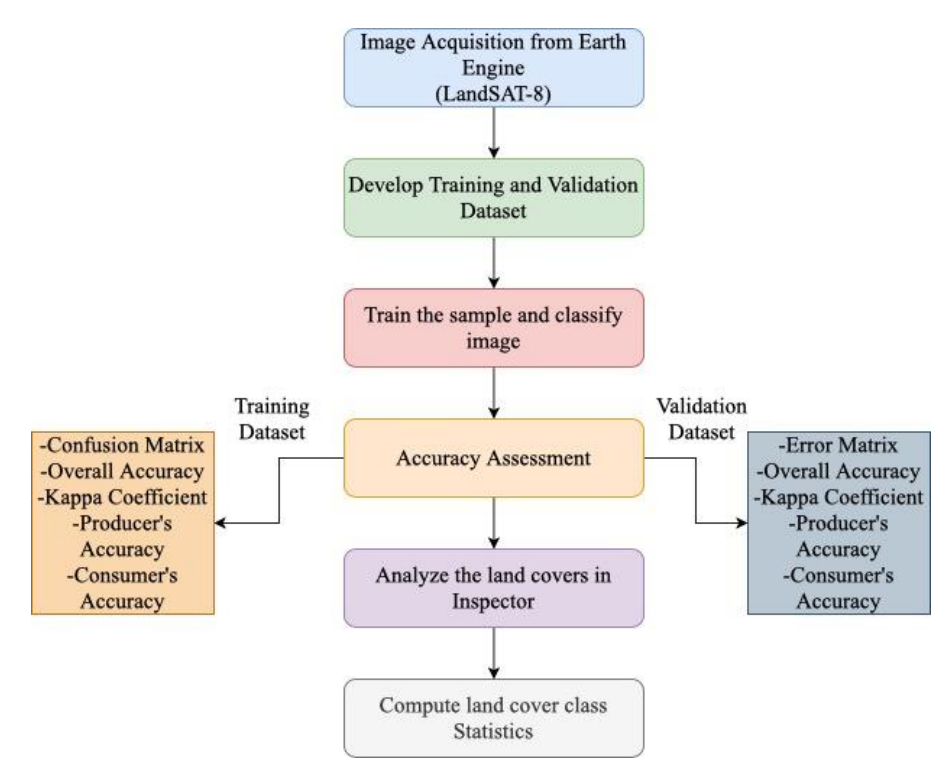

## **Setting up the conda enviornment**

```
conda create -n geo python=3.8
conda activate geo
conda install geemap -c conda-forge
conda install jupyter_contrib_nbextensions -c conda-forge
jupyter contrib nbextension install --user
```

## **Setting up in google colaboratory**
```
!pip install geemap
```

## **Regular run from conda and Jupyter**
```
conda activate [enviornment name]
jupyter notebook
```

# **Uncomment (Remove # only) and install the following when using for the first time.**

In [ ]:
#!pip install geemap

# **Import required modules**

In [1]:
import os
import ee
import geemap

# **Supervised Classification**

In [ ]:
#!pip install -U ipyleaflet==0.13.3

## **Landcover for year 2013**

### **Add data to the map from earth engine**


In [2]:
Map = geemap.Map()

nepal_vec = './Data in GCS_WGS 84/KBL.shp'
ROI = geemap.shp_to_ee(nepal_vec)

image1 = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA') \
    .filterBounds(ROI) \
    .filterDate('2013-01-01', '2013-12-30') \
    .sort('CLOUD_COVER') \
    .first() \
    .select('B[1-7]') \
    .clip(ROI)  


vis_params = {
    'bands': ['B5', 'B4', 'B3']
}

Map.centerObject(ROI, 10)
Map.addLayer(image1, vis_params, "Landsat-8 2013")

Map

Map(center=[27.64112943284826, 85.35991732243264], controls=(WidgetControl(options=['position'], widget=HBox(c…

In [ ]:
#Map.addLayer(ROI, {}, "kBL")

In [ ]:
# Map.user_rois.getInfo()

In [ ]:
# region = Map.user_rois
# region

In [ ]:
#geemap.ee_to_shp(region, filename='./Data in GCS_WGS 84/region_saved.shp')

In [3]:
region_new = './Data in GCS_WGS 84/region_saved.shp'
region = geemap.shp_to_ee(region_new)
region

C:\Users\rajbh\.conda\envs\geemap\lib\site-packages\shapefile.py:391: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


In [11]:
region.getInfo()

{'type': 'FeatureCollection',
 'columns': {'color': 'String',
  'label': 'String',
  'landcover': 'Integer',
  'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[85.314663, 27.70793],
      [85.315907, 27.70793],
      [85.315907, 27.70834],
      [85.314663, 27.70834],
      [85.314663, 27.70793]]]},
   'id': '0',
   'properties': {'color': '#3388ff', 'label': 'water', 'landcover': 0}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[85.314672, 27.707307],
      [85.316106, 27.707307],
      [85.316106, 27.707675],
      [85.314672, 27.707675],
      [85.314672, 27.707307]]]},
   'id': '1',
   'properties': {'color': '#3388ff', 'label': 'water', 'landcover': 0}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[85.324776, 27.710446],
      [85.325609, 27.710446],
      [85.325609, 27.711016],
      [85.324776, 27.711016],
      [85.324776, 27.710446]]]},
   '

### **Make Training Dataset**

In [4]:
samples = region

Map.addLayer(samples, {}, 'training', False)

In [5]:
samples.size().getInfo()

117

In [6]:
samples.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[85.314663, 27.70793],
    [85.315907, 27.70793],
    [85.315907, 27.70834],
    [85.314663, 27.70834],
    [85.314663, 27.70793]]]},
 'id': '0',
 'properties': {'color': '#3388ff', 'label': 'water', 'landcover': 0}}

### **Split training and testing as well as Train the classifier**

In [7]:
# Use these bands for prediction.
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']


# This property stores the land cover labels.
label = 'landcover'

# Overlay the points on the imagery to get training.
sample1 = image1.select(bands).sampleRegions(**{
  'collection': samples,
  'properties': [label],
  'scale': 30
})

# Adds a column of deterministic pseudorandom numbers. 
sample1 = sample1.randomColumn()

split = 0.7

training1 = sample1.filter(ee.Filter.lt('random', split))
validation1 = sample1.filter(ee.Filter.gte('random', split))


In [8]:
training1.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '0_0',
 'properties': {'B1': 0.1199425682425499,
  'B2': 0.10332363843917847,
  'B3': 0.1002737283706665,
  'B4': 0.08097834885120392,
  'B5': 0.14110523462295532,
  'B6': 0.10431953519582748,
  'B7': 0.06790728121995926,
  'landcover': 0,
  'random': 0.3903273345910523}}

In [9]:
validation1.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '0_1',
 'properties': {'B1': 0.1200048103928566,
  'B2': 0.10148746520280838,
  'B3': 0.09918446838855743,
  'B4': 0.07917329668998718,
  'B5': 0.12570005655288696,
  'B6': 0.0700857937335968,
  'B7': 0.04889199882745743,
  'landcover': 0,
  'random': 0.796006026040637}}

In [12]:
# Train a CART classifier with default parameters.
trained1 = ee.Classifier.smileCart().train(training1, label, bands)

### **Clasify the image**

In [13]:
# Classify the image with the same bands used for training.
result1 = image1.select(bands).classify(trained1)

# # Display the clusters with random colors.
Map.addLayer(result1.randomVisualizer(), {}, 'classfied')
Map

Map(bottom=110415.0, center=[27.64112943284826, 85.35991732243264], controls=(WidgetControl(options=['position…

### **Render Map**

In [14]:
legend_keys = ['Water', 'Forest', 'Vegetation','Bare Land', 'Builtup']
legend_colors = ['#3388ff', '#025a11', '#88f299', '#bdbdbd','#ff00ae']


# Reclassify the map
result1 = result1.remap([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

Map.addLayer(result1, {'min': 1, 'max': 5, 'palette': legend_colors}, 'Labelled lancover 2013')
Map.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')
Map

Map(bottom=220522.0, center=[27.64582289489237, 85.3462600708008], controls=(WidgetControl(options=['position'…

### **Accuracy Assessment of Training Dataset**

#### **Confusion Matrix**

In [15]:
train_accuracy = trained1.confusionMatrix()

In [16]:
train_accuracy.getInfo()

[[36, 0, 0, 0, 0],
 [0, 18256, 0, 0, 0],
 [0, 0, 128, 0, 0],
 [0, 0, 0, 33, 0],
 [0, 0, 0, 0, 318]]

#### **Overall Accuracy**

In [ ]:
train_accuracy.accuracy().getInfo()

#### **Kappa Coefficient**

In [ ]:
train_accuracy.kappa().getInfo()

#### **Producer's Accuracy**

In [ ]:
train_accuracy.producersAccuracy().getInfo()

#### **Consumer's Accuracy**

In [ ]:
train_accuracy.consumersAccuracy().getInfo()

### **Accuracy assessment of Validation Dataset**

#### **Classify the validation area based on the same trained classifier**

In [17]:
validated = validation1.classify(trained1)

In [18]:
validated.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '0_1',
 'properties': {'B1': 0.1200048103928566,
  'B2': 0.10148746520280838,
  'B3': 0.09918446838855743,
  'B4': 0.07917329668998718,
  'B5': 0.12570005655288696,
  'B6': 0.0700857937335968,
  'B7': 0.04889199882745743,
  'classification': 0,
  'landcover': 0,
  'random': 0.796006026040637}}

#### **Error Matrix**

In [19]:
test_accuracy = validated.errorMatrix('landcover', 'classification')

In [20]:
test_accuracy.getInfo()

[[11, 1, 0, 0, 0],
 [2, 7734, 0, 2, 0],
 [1, 1, 49, 0, 0],
 [0, 4, 2, 23, 0],
 [0, 0, 2, 0, 100]]

#### **Overall Accuracy**

In [21]:
test_accuracy.accuracy().getInfo()

0.9981089258698941

#### **Kappa Coefficient**

In [22]:
test_accuracy.kappa().getInfo()

0.9604810562831064

#### **Producer's Accuracy**

In [23]:
test_accuracy.producersAccuracy().getInfo()

[[0.9166666666666666],
 [0.9994830705608685],
 [0.9607843137254902],
 [0.7931034482758621],
 [0.9803921568627451]]

#### **Consumer's Accuracy**

In [24]:
test_accuracy.consumersAccuracy().getInfo()

[[0.7857142857142857, 0.9992248062015504, 0.9245283018867925, 0.92, 1]]

### **Download confusion and error matrix**

In [ ]:
import csv
import os

out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
training_csv = os.path.join(out_dir, 'train_accuracy.csv')
testing_csv = os.path.join(out_dir, 'test_accuracy.csv')

with open(training_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(train_accuracy.getInfo())
    
with open(testing_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(test_accuracy.getInfo())

## **Landcover for year 2017**

### **Add data to the map from earth engine**


In [72]:
image2 = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA') \
    .filterBounds(ROI) \
    .filterDate('2018-01-01', '2018-12-30') \
    .sort('CLOUD_COVER') \
    .first() \
    .select('B[1-7]') \
    .clip(ROI)  

Map.addLayer(image2, vis_params, "Landsat-8 2017")
Map

Map(bottom=440604.0, center=[27.688392321785685, 85.32480239868164], controls=(WidgetControl(options=['positio…

In [ ]:
# region_new = './Data in GCS_WGS 84/region_saved.shp'
# region = geemap.shp_to_ee(region_new)
# region

### **Make Training Dataset**

In [ ]:
# samples = region

# Map.addLayer(samples, {}, 'training', False)

In [ ]:
# samples.size().getInfo()

In [ ]:
# samples.first().getInfo()

### **Split training and testing as well as Train the classifier**

In [73]:
# Overlay the points on the imagery to get training.
sample2 = image2.select(bands).sampleRegions(**{
  'collection': samples,
  'properties': [label],
  'scale': 30
})

# Adds a column of deterministic pseudorandom numbers. 
sample2 = sample2.randomColumn()

split = 0.7

training2 = sample2.filter(ee.Filter.lt('random', split))
validation2 = sample2.filter(ee.Filter.gte('random', split))


In [27]:
training2.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '0_0',
 'properties': {'B1': 0.14748205244541168,
  'B2': 0.13095645606517792,
  'B3': 0.11588724702596664,
  'B4': 0.11359862983226776,
  'B5': 0.21495167911052704,
  'B6': 0.19408662617206573,
  'B7': 0.16822822391986847,
  'landcover': 0,
  'random': 0.37855295723889426}}

In [28]:
validation2.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '1_0',
 'properties': {'B1': 0.1377628594636917,
  'B2': 0.11885947734117508,
  'B3': 0.10224471241235733,
  'B4': 0.0871160551905632,
  'B5': 0.3224869668483734,
  'B6': 0.15562596917152405,
  'B7': 0.09647858142852783,
  'landcover': 0,
  'random': 0.915860877191023}}

In [74]:
# Train a CART classifier with default parameters.
trained2 = ee.Classifier.smileCart().train(training2, label, bands)

### **Clasify the image**

In [75]:
# Classify the image with the same bands used for training.
result2 = image2.select(bands).classify(trained2)

# # Display the clusters with random colors.
Map.addLayer(result2.randomVisualizer(), {}, 'classfied2')
Map

Map(bottom=440604.0, center=[27.688392321785685, 85.32480239868164], controls=(WidgetControl(options=['positio…

### **Render Map**

In [76]:
# Reclassify the map
result2 = result2.remap([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

Map.addLayer(result2, {'min': 1, 'max': 5, 'palette': legend_colors}, 'Labelled landcover 2017')
Map

Map(bottom=220453.0, center=[27.687784303885763, 85.37578582763672], controls=(WidgetControl(options=['positio…

### **Accuracy accessment of Validation Dataset**

#### **Classify the validation area based on the same trained classifier**

In [34]:
validated2 = validation2.classify(trained2)

In [35]:
validated2.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '0_1',
 'properties': {'B1': 0.14584732055664062,
  'B2': 0.1291433870792389,
  'B3': 0.11722475290298462,
  'B4': 0.11434168368577957,
  'B5': 0.21929113566875458,
  'B6': 0.20133885741233826,
  'B7': 0.177887961268425,
  'classification': 0,
  'landcover': 0,
  'random': 0.7044789510018293}}

#### **Error Matrix**

In [36]:
test_accuracy = validated2.errorMatrix('landcover', 'classification')

In [37]:
test_accuracy.getInfo()

[[12, 1, 1, 0, 0],
 [1, 7727, 0, 3, 0],
 [1, 0, 53, 5, 3],
 [0, 3, 3, 13, 0],
 [0, 0, 0, 0, 124]]

#### **Overall Accuracy**

In [38]:
test_accuracy.accuracy().getInfo()

0.9973584905660378

#### **Kappa Coefficient**

In [39]:
test_accuracy.kappa().getInfo()

0.9511021708351618

#### **Producer's Accuracy**

In [40]:
test_accuracy.producersAccuracy().getInfo()

[[0.8571428571428571],
 [0.9994826025093778],
 [0.8548387096774194],
 [0.6842105263157895],
 [1]]

#### **Consumer's Accuracy**

In [41]:
test_accuracy.consumersAccuracy().getInfo()

[[0.8571428571428571,
  0.9994826025093778,
  0.9298245614035088,
  0.6190476190476191,
  0.9763779527559056]]

### **Download confusion and error matrix**

In [ ]:
import csv
import os

out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
training_csv = os.path.join(out_dir, 'train_accuracy2017.csv')
testing_csv = os.path.join(out_dir, 'test_accuracy2017.csv')

with open(training_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(train_accuracy.getInfo())
    
with open(testing_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(test_accuracy.getInfo())

## **Landcover for year 2021**

### **Add data to the map from earth engine**


In [42]:
image3 = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA') \
    .filterBounds(ROI) \
    .filterDate('2021-01-01', '2021-12-30') \
    .sort('CLOUD_COVER') \
    .first() \
    .select('B[1-7]') \
    .clip(ROI)  

Map.addLayer(image3, vis_params, "Landsat-8 2021")

Map

Map(bottom=881090.3999938965, center=[27.660724080406634, 85.32368659973146], controls=(WidgetControl(options=…

In [ ]:
# region_new = './Data in GCS_WGS 84/region_saved.shp'
# region = geemap.shp_to_ee(region_new)
# region

### **Make Training Dataset**

In [ ]:
# samples = region

# Map.addLayer(samples, {}, 'training', False)

In [ ]:
# samples.size().getInfo()

In [ ]:
# samples.first().getInfo()

### **Split training and testing as well as Train the classifier**

In [43]:
# Overlay the points on the imagery to get training.
sample3 = image3.select(bands).sampleRegions(**{
  'collection': samples,
  'properties': [label],
  'scale': 30
})

# Adds a column of deterministic pseudorandom numbers. 
sample3 = sample3.randomColumn()

split = 0.7

training3 = sample3.filter(ee.Filter.lt('random', split))
validation3 = sample3.filter(ee.Filter.gte('random', split))


In [44]:
training3.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '0_1',
 'properties': {'B1': 0.17330145835876465,
  'B2': 0.15618905425071716,
  'B3': 0.13868583738803864,
  'B4': 0.12980860471725464,
  'B5': 0.18700812757015228,
  'B6': 0.12718451023101807,
  'B7': 0.10180902481079102,
  'landcover': 0,
  'random': 0.5257647800315902}}

In [45]:
validation3.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '0_0',
 'properties': {'B1': 0.17469725012779236,
  'B2': 0.1576685905456543,
  'B3': 0.1398024708032608,
  'B4': 0.1329910010099411,
  'B5': 0.19030219316482544,
  'B6': 0.1569986194372177,
  'B7': 0.12037304788827896,
  'landcover': 0,
  'random': 0.835012035781178}}

In [46]:
# Train a CART classifier with default parameters.
trained3 = ee.Classifier.smileCart().train(training3, label, bands)

### **Clasify the image**

In [47]:
# Classify the image with the same bands used for training.
result3 = image3.select(bands).classify(trained3)

# # Display the clusters with random colors.
Map.addLayer(result3.randomVisualizer(), {}, 'classfied')
Map

Map(bottom=220676.0, center=[27.552111841284695, 85.37029266357423], controls=(WidgetControl(options=['positio…

### **Render Map**

In [48]:
# Reclassify the map
result3 = result3.remap([0, 1, 2, 3, 4], [1, 2, 3, 4, 5])

Map.addLayer(result3, {'min': 1, 'max': 5, 'palette': legend_colors}, 'Labelled classifiers 2021')

Map

Map(bottom=220544.0, center=[27.632440508426797, 85.36342620849611], controls=(WidgetControl(options=['positio…

### **Accuracy accessment of Validation Dataset**

#### **Classify the validation area based on the same trained classifier**

In [49]:
validated3 = validation3.classify(trained3)

In [50]:
validated3.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '0_0',
 'properties': {'B1': 0.17469725012779236,
  'B2': 0.1576685905456543,
  'B3': 0.1398024708032608,
  'B4': 0.1329910010099411,
  'B5': 0.19030219316482544,
  'B6': 0.1569986194372177,
  'B7': 0.12037304788827896,
  'classification': 4,
  'landcover': 0,
  'random': 0.835012035781178}}

#### **Error Matrix**

In [51]:
test_accuracy = validated3.errorMatrix('landcover', 'classification')

In [52]:
test_accuracy.getInfo()

[[10, 0, 0, 0, 1],
 [0, 7776, 2, 3, 2],
 [1, 2, 54, 0, 2],
 [0, 1, 0, 19, 0],
 [0, 0, 1, 0, 126]]

#### **Overall Accuracy**

In [53]:
test_accuracy.accuracy().getInfo()

0.998125

#### **Kappa Coefficient**

In [54]:
test_accuracy.kappa().getInfo()

0.9650704035125209

#### **Producer's Accuracy**

In [55]:
test_accuracy.producersAccuracy().getInfo()

[[0.9090909090909091],
 [0.9991006038802518],
 [0.9152542372881356],
 [0.95],
 [0.9921259842519685]]

#### **Consumer's Accuracy**

In [56]:
test_accuracy.consumersAccuracy().getInfo()

[[0.9090909090909091,
  0.9996143463170073,
  0.9473684210526315,
  0.8636363636363636,
  0.9618320610687023]]

### **Download confusion and error matrix**

In [ ]:
import csv
import os

out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
training_csv = os.path.join(out_dir, 'train_accuracy2021.csv')
testing_csv = os.path.join(out_dir, 'test_accuracy2021.csv')

with open(training_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(train_accuracy.getInfo())
    
with open(testing_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(test_accuracy.getInfo())

##  **Analyze the landcovers in inspector**

In [ ]:
# left_layer = geemap.ee_tile_layer(result1, {'min': 1, 'max': 3, 'palette': legend_colors}, '2013')
# right_layer = geemap.ee_tile_layer(result3, {'min': 1, 'max': 3, 'palette': legend_colors}, '2021')
# Map.split_map(right_layer, left_layer)
# Map

In [77]:
series = ee.ImageCollection([result1, result2, result3])

In [78]:
series_layer_names = ['Landsat8 Landcover 2013', 'Landsat8 Landcover 2017', 'Landsat8 Landcover 2021']
vis = {'min': 1, 'max': 5, 'bands': ['remapped'], 'palette': legend_colors}

In [ ]:
# Map.ts_inspector(left_ts=series, right_ts=series, left_names=series_layer_names, 
#                  right_names=series_layer_names, left_vis=vis, right_vis=vis)
# Map.centerObject(ROI, zoom=8)
# Map

In [79]:
m = geemap.Map()
m.ts_inspector(left_ts=series, right_ts=series, left_names=series_layer_names, 
                 right_names=series_layer_names, left_vis=vis, right_vis=vis)
m.centerObject(ROI, zoom=7)
m.add_legend(legend_keys=legend_keys, legend_colors=legend_colors, position='bottomright')
m

Map(center=[27.64112943284826, 85.35991732243264], controls=(WidgetControl(options=['position'], widget=Dropdo…

## **Calculate class percentage**

In [63]:
nepal = './Data in GCS_WGS 84/KBL_Dissolve.shp'
nep = geemap.shp_to_ee(nepal)

In [69]:
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
landcover_stats = os.path.join(out_dir, 'landcover_stats2021.csv')  

if not os.path.exists(out_dir):
    os.makedirs(out_dir)    
    
# statistics_type can be either 'SUM' or 'PERCENTAGE'
# denominator can be used to convert square meters to other areal units, such as square kilimeters
geemap.zonal_statistics_by_group(result1, nep, landcover_stats, statistics_type='PERCENTAGE', decimal_places=2)


Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\rajbh\Downloads\landcover_stats2013.csv


In [67]:
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
landcover_stats = os.path.join(out_dir, 'landcover_stats2013.csv')  

if not os.path.exists(out_dir):
    os.makedirs(out_dir)    
    
# statistics_type can be either 'SUM' or 'PERCENTAGE'
# denominator can be used to convert square meters to other areal units, such as square kilimeters
geemap.zonal_statistics_by_group(result3, nep, landcover_stats, statistics_type='PERCENTAGE', decimal_places=2)


Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\rajbh\Downloads\landcover_stats2021.csv


# **Export the result**

In [68]:
import os
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
out_file = os.path.join(out_dir, 'landcover1.tif')
geemap.ee_export_image(result1, filename=out_file, scale=900)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\rajbh\Downloads\landcover1.tif
